In [72]:
from astropy.table import Table

def read_ecsv_file(filename):
    if not filename.lower().endswith(".ecsv"):
        raise ValueError("Unsupported file format. Only ECSV is supported.")
    
    format = "ascii.ecsv"
    x_col = 'jd'
    y_col = 'flux'
    
    table = Table.read(filename, format=format)
    
    if x_col not in table.colnames or y_col not in table.colnames:
        raise ValueError(f"Input file must contain '{x_col}' and '{y_col}' columns.")
    
    return table

# Example usage
filename = "../../tess_curves/lc_tess_W UMa_TIC_446127290_img_TPF_sector_74.ecsv"
table = read_ecsv_file(filename)


In [59]:
import matplotlib.pyplot as plt
import os

def plot_lightcurve(filename):
    """
    Plots a light curve from a CSV or ECSV file.

    Args:
        filename (str): Path to the file.
    """
    try:
        # Determine file format and expected columns
        if filename.lower().endswith(".ecsv"):
            format = "ascii.ecsv"
            x_col = 'jd'
            y_col = 'flux'
            plot_type = "Raw"
            x_label = "Julian Date (JD)"
        elif filename.lower().endswith(".csv"):
            format = "csv"
            x_col = 'phase'
            y_col = 'normalized_flux'
            plot_type = "Folded"
            x_label = "Phase"
        else:
            raise ValueError("Unsupported file format. Only CSV and ECSV are supported.")

        table = Table.read(filename, format=format)

        if x_col not in table.colnames or y_col not in table.colnames:
            raise ValueError(f"Input file must contain '{x_col}' and '{y_col}' columns.")

        x = table[x_col]
        y = table[y_col]

        plt.figure(figsize=(10, 6))
        plt.plot(x, y, marker='.', linestyle='-', markersize=2 if plot_type=="Raw" else 5) # smaller markersize for raw
        plt.xlabel(x_label)
        plt.ylabel(y_col.capitalize())
        plt.title(f"{plot_type} Light Curve: {os.path.basename(filename)}")
        plt.grid(True)
        if plot_type == "Folded":
            plt.gca().invert_yaxis()
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found: {filename}")
    except ValueError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

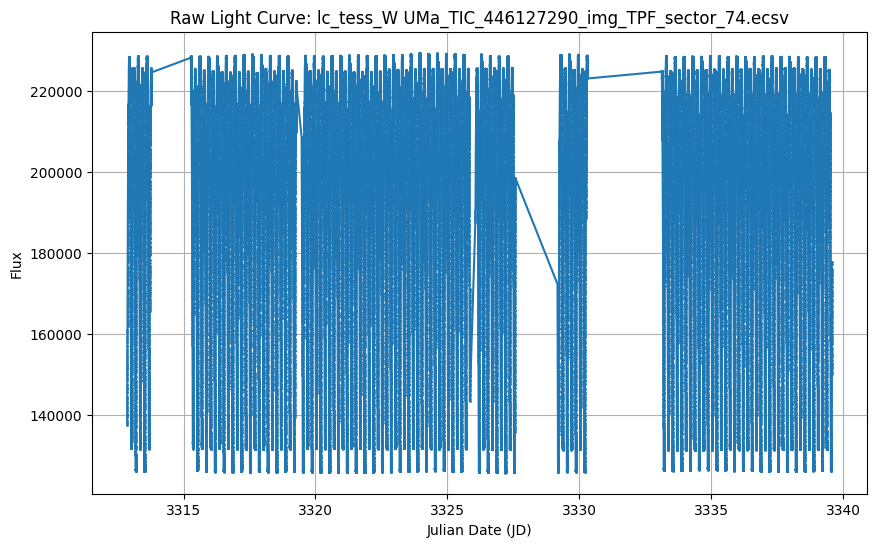

In [73]:
plot_lightcurve(filename=filename)

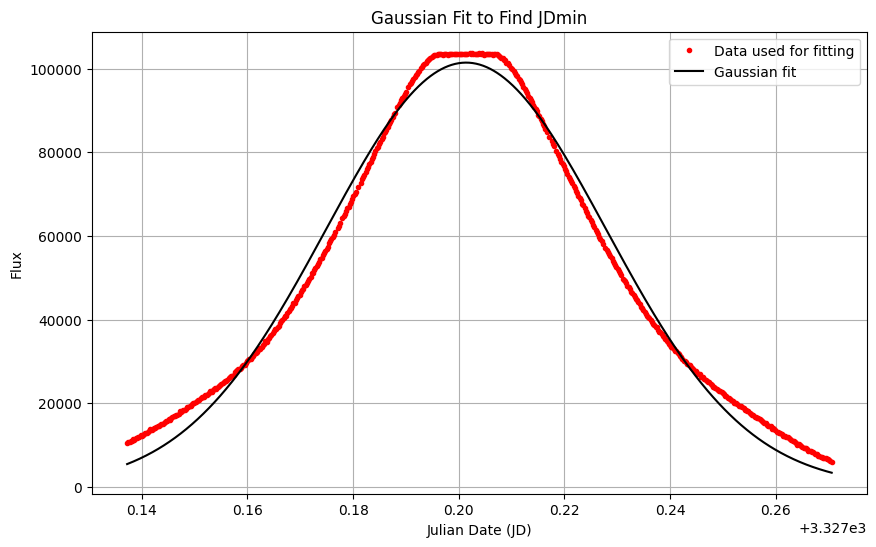

The JDmin (center of eclipse) is: 3327.2013825867366


In [74]:
from scipy.optimize import curve_fit
import numpy as np

def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def find_jdmin(table, period):
    """
    Finds the JDmin, which is the center of an eclipse, from the light curve data by fitting a Gaussian model.

    Args:
        table (astropy.table.Table): The light curve data table.
        period (float): The orbital period of the light curve.

    Returns:
        float: The Julian Date (JD) corresponding to the center of the eclipse.
    """
    x = table['jd']
    y = table['flux'].max() - table['flux']

    # Initial guess for the parameters
    initial_guess = [max(y), x[np.argmax(y)], 0.2 * period]

    # Take points around the initial guess within 0.2 of the period
    mask = (x > initial_guess[1] - 0.2 * period) & (x < initial_guess[1] + 0.2 * period)
    x_fit = x[mask]
    y_fit = y[mask]

    try:
        # Fit the Gaussian model to the data
        popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=initial_guess)

        # The center of the eclipse is the mean of the Gaussian
        jdmin = popt[1]

        # Plot the data points used for fitting
        plt.figure(figsize=(10, 6))
        plt.plot(x_fit, y_fit, 'r.', label='Data used for fitting')

        # Plot the Gaussian fit
        x_fit_line = np.linspace(min(x_fit), max(x_fit), 1000)
        y_fit_line = gaussian(x_fit_line, *popt)
        plt.plot(x_fit_line, y_fit_line, 'k-', label='Gaussian fit')

        plt.xlabel('Julian Date (JD)')
        plt.ylabel('Flux')
        plt.title('Gaussian Fit to Find JDmin')
        plt.legend()
        plt.grid(True)
        plt.show()
        return jdmin
    except RuntimeError:
        print("Gaussian fit did not converge. Plotting the chosen part of the light curve.")
        plt.figure(figsize=(10, 6))
        plt.plot(x_fit, y_fit, 'r.', label='Data used for fitting')
        plt.xlabel('Julian Date (JD)')
        plt.ylabel('Flux')
        plt.title('Chosen Part of the Light Curve')
        plt.legend()
        plt.grid(True)
        plt.show()
        return None

# Example usage
period = 0.33363551
jdmin = find_jdmin(table, period)
print(f"The JDmin (center of eclipse) is: {jdmin}")

In [75]:
def fold_lightcurve(table, jdmin, period):
    """
    Folds the light curve data using the given period and JDmin.

    Args:
        table (astropy.table.Table): The light curve data table.
        jdmin (float): The Julian Date (JD) corresponding to the center of the eclipse.
        period (float): The period of the light curve.

    Returns:
        astropy.table.Table: The folded light curve data table.
    """
    x = table['jd']
    y = table['flux']

    # Calculate the phase and normalize it to be between 0 and 1
    phase = ((x - jdmin) / period) % 1
    phase[phase < 0] += 1

    # Create a new table with the phase and flux
    folded_table = Table([phase, y], names=('phase', 'flux'))
    return folded_table

folded_table = fold_lightcurve(table, jdmin, period)
#print(folded_table)

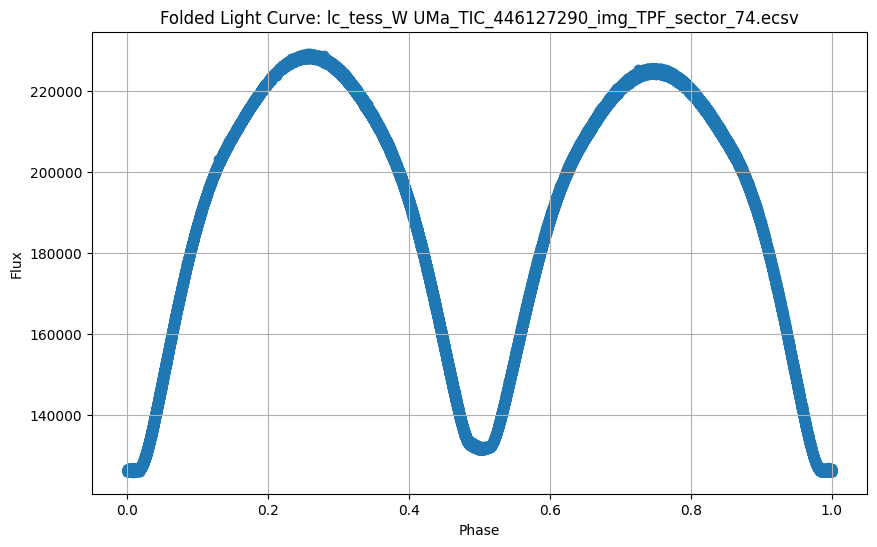

In [76]:
plt.figure(figsize=(10, 6))
plt.scatter(folded_table['phase'], folded_table['flux'])
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.title(f"Folded Light Curve: {os.path.basename(filename)}")
plt.grid(True)
plt.gca()
plt.show()